# Predicting Cyclic Voltammetry with Physics-Informed Neural Networks

This notebook was adapted from [Dr. Haotian Chen's notebook](https://github.com/nmerovingian/PINN-CV). We sincerely appreciate Dr. Chen's help during the preparation of this tutorial.

In this tutorial, we solve a forward problem, predicting how electrical current changes as we change the voltage in a chemical system.

## 1. Setup

In [1]:
# Core libraries
import numpy as np
import pandas as pd

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# Plotting aesthetics
import matplotlib.pyplot as plt

# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Problem definition

This problem focuses on predicting output of an electroanalytical technique known as __voltammetry__. Consider an electrode immersed in a chemical solution. When an electrical potential is applied to this electrode and varied over time, it causes chemical reactions to occur at the electrode's surface. These reactions alter the __concentration of the chemical species__ near the electrode. The rate at which the species moves towards or away from the electrode surface due to these concentration changes is called __flux__. This flux generates an electrical __current__. The resulting plot of current (or flux) versus the applied potential is the __voltammogram__, which is a characteristic signature of the electrochemical system.

![Voltammetry](https://mtxlabsglobal.com/wp-content/uploads/2023/10/MTX-Labs-cyclic-voltammogramCV-obtained-from-cyclic-voltammetry-measurements-1024x553.png)

The core task is to model how the concentration of the chemical species, denoted as $C(t,x)$ (concentration as a function of time $t$ and distance $x$ from the electrode), evolves. This evolution is governed by __Fick's second law of diffusion__, a partial differential equation (PDE) that describes how substances spread out.

$$
\frac{\partial C}{\partial t} = D \frac{\partial^2 C}{\partial x^2}
$$

$C=C(t,x)$: concentration

$t$: time

$x$: position (distance from the electrode)

$D$: diffusion coefficient (a constant)

To understand this equation intuitively, the rate at which concentration changes over time at any point depends on how uneven or "curvy" the concentration is nearby. If the concentration is higher in one place and lower nearby, the substance will spread out from high to low, smoothing out the concentration over time. The equation says this spreading happens in a way proportional to how curved the concentration profile is.

__Initial Condition:__

At the beginning of the experiment ($t=0$), the chemical species is assumed to be uniformly distributed throughout the solution with a known bulk concentration, here assumed to be 1.

__Boundary Conditions:__

Electrode surface condition: At the electrode surface (position $x=0$), the concentration is not fixed but is dynamically related to the instantaneous applied electrical potential via the __Nernst equation__. The __Nerst boundary condition__ describes the relationship of surface concentration and applied potential. Here, we omit the equation for the surface concentration and provide the python code to simulate it.

Semi-infinite boundary condition: Far from the electrode (at a semi-infinite boundary, $x→∞$), the concentration is assumed to remain undisturbed at its initial bulk value, as the effects of the electrode do not reach that far within the timeframe of the experiment.

We simulate a cyclic voltammetric scan, starting at concentration 1 with a potential of 10, reversing at concentration 0 with a potential of -10, and a scan rate $\sigma$ of 40, which describes the maximum rate of change of the boundary concentration over time.

In [2]:
# Problem setup
sigma = 40.0  #Dimensionless scan rate
theta_i = 10.0  #Dimensionless start potential
theta_v = -10.0 #Dimensionless reverse potential

maxT = 2.0*abs(theta_v-theta_i)/sigma  # total time of voltammetric scan
maxX =  6.0 * np.sqrt(maxT)  # the max diffusion length dictating the outer boundary of simulation

We can simulate and visualize the Nerst boundary condition under this setup.

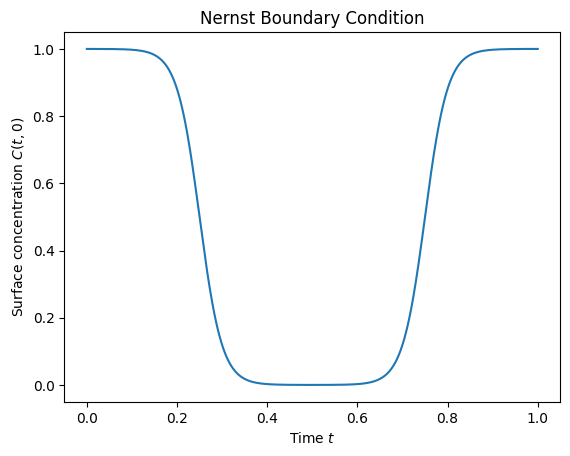

In [4]:
def Nernst(t,sigma,theta_i,theta_v,maxT):
    if t < maxT/2.0:
        c =  1.0/(1.0+np.exp(-(theta_i-sigma*t)))
    elif t>= maxT/2.0:
        c = 1.0/(1.0+np.exp(-(theta_v+sigma*(t-maxT/2.0))))

    return c

# Let's now visualize this relationship
time_series = np.linspace(0,maxT,num=500)

c_series = [Nernst(t,sigma,theta_i,theta_v,maxT) for t in time_series]

fig,ax = plt.subplots()
ax.plot(time_series,c_series)
ax.set_xlabel('Time $t$');
ax.set_ylabel('Surface concentration $C(t,0)$');
ax.set_title('Nernst Boundary Condition');

The objective is to use a PINN to learn the spatio-temporal concentration profile $C(t,x)$. The PINN is trained to satisfy Fick's law throughout the domain, as well as the specified initial and boundary conditions. Once $C(t,x)$ is accurately predicted, the flux at the electrode surface can be calculated. This flux, when plotted against the corresponding applied potential, yields the desired voltammogram. This is a __forward problem__: given all the physical laws and parameters, the PINN predicts the system's behavior.


## 3. Data generation

We always need to generate some of the __training "data"__ for physics-informed neural networks. For this problem, we need three sets of data to carry information in the PDE, initial condition, and boundary condition. This is done by generating three sets of __collocation points__ and calculate the corresponding target values.

We first generate collocation points.

In [5]:
def genCollocation(num_train_samples=1000,maxX=1.0,maxT=1.0):
    # create training input
    # Collocation points covering the entire simulation domain and entire time to enforce the underlying partial differential equation.
    tx_eqn = np.random.rand(num_train_samples, 2)
    tx_eqn[...,0] = tx_eqn[...,0] * maxT
    tx_eqn[...,1] = tx_eqn[...,1] * maxX

    # Collocation points covering the entire simulation domain but only at T=0 to enforce the initial condition
    tx_ini = np.random.rand(num_train_samples, 2)
    tx_ini[..., 0] = 0
    tx_ini[...,1] = tx_ini[...,1] * maxX

    # Collocation points at the electrode surface (X=0)
    tx_bnd0 = np.random.rand(num_train_samples, 2)
    tx_bnd0[...,0] = tx_bnd0[...,0] * maxT
    tx_bnd0[...,1] = 0.0

    # Collocation points at the semi-infinite boundary
    tx_bnd1 = np.random.rand(num_train_samples, 2)
    tx_bnd1[...,0] = tx_bnd1[...,0] * maxT
    tx_bnd1[...,1] =  maxX

    return tx_eqn,tx_ini,tx_bnd0,tx_bnd1

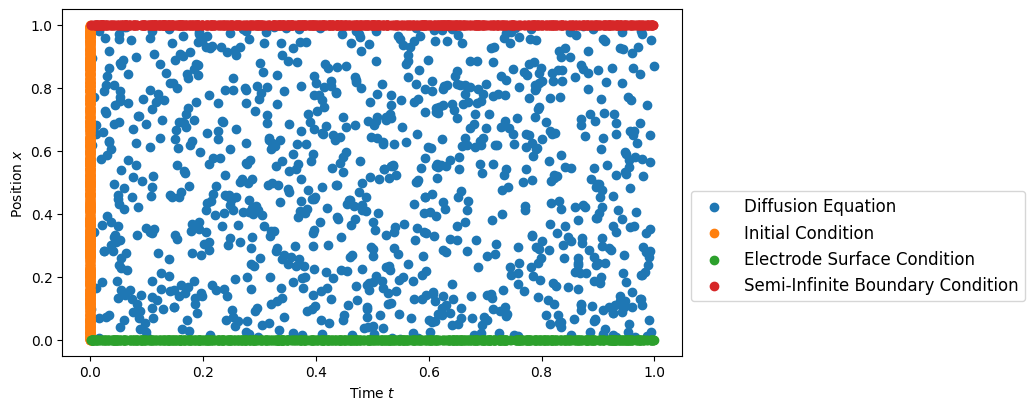

In [6]:
# Visualize collcation points
tx_eqn,tx_ini,tx_bnd0,tx_bnd1 = genCollocation()

fig,ax = plt.subplots(figsize=(8,4.5))

ax.scatter(tx_eqn[:,0],tx_eqn[:,1],label='Diffusion Equation')
ax.scatter(tx_ini[:,0],tx_ini[:,1],label='Initial Condition')
ax.scatter(tx_bnd0[:,0],tx_bnd0[:,1],label='Electrode Surface Condition')
ax.scatter(tx_bnd1[:,0],tx_bnd1[:,1],label='Semi-Infinite Boundary Condition')
ax.legend(fontsize=12,bbox_to_anchor=(1, 0.5))

ax.set_xlabel('Time $t$');
ax.set_ylabel('Position $x$');

We then simulate training targets at these collocation points. The target could be zero, one, or an exact solution, depending on the equation or condition to enforce.

Text(0, 0.5, 'Surface concentration $C(t,0)$')

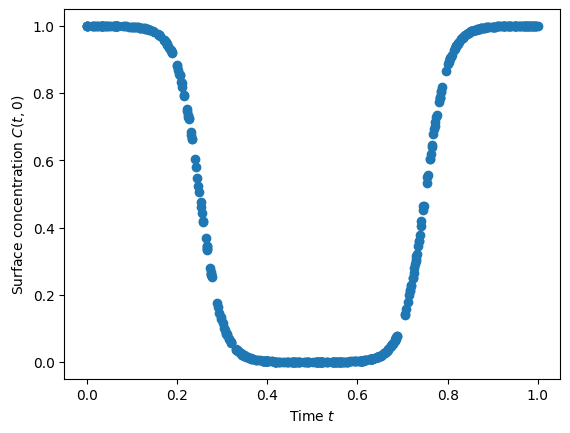

In [7]:
# number of training samples
num_train_samples = 100000
# number of test samples
num_test_samples = 1000

# Generate training inputs
tx_eqn,tx_ini,tx_bnd0,tx_bnd1 = genCollocation(num_train_samples=num_train_samples,maxX=maxX,maxT=maxT)

# Create training targets
c_eqn = np.zeros((num_train_samples, 1)) # Targets for enforcing the governing equation (zero)

c_ini = np.ones((num_train_samples,1)) # Targets for enforcing the initial conditions (one)

c_bnd0 = np.ones((num_train_samples,1)) # Calculate the surface concentration according to the time in the tx_bnd0

for i in range(num_train_samples):
    c_bnd0[i] = Nernst(tx_bnd0[i,0],sigma,theta_i,theta_v,maxT)

c_bnd1 = np.ones((num_train_samples,1)) # Targets for enforcing the semi-infinite boudary conditions (one)

# Gather the training inputs and outputs
x_train = [torch.tensor(x, dtype=torch.float32) for x in [tx_eqn, tx_ini, tx_bnd0, tx_bnd1]]
y_train = [torch.tensor(y, dtype=torch.float32) for y in [c_eqn, c_ini, c_bnd0, c_bnd1]]

# Visualize the Nernst boundary condition again, but this time, we will use a scatter plot for the data we generated
fig, ax = plt.subplots()
ax.scatter(tx_bnd0[:500,0],c_bnd0[:500])
ax.set_xlabel('Time $t$')
ax.set_ylabel('Surface concentration $C(t,0)$')

## 4. Neural network

Build a fully connected neural network with $(t,x)$ as input and $C(t,x)$ as output.

The input shape should be `(batch_size, 2)`, and output shape should be `(batch_size,1)`.

In [8]:
# Network Definition
class Network(nn.Module):
    def __init__(self, num_inputs=2, layers=[32, 16, 32], activation='tanh', num_outputs=1):
        super().__init__()
        self.activation = self.get_activation(activation)
        layer_sizes = [num_inputs] + layers + [num_outputs]
        self.layers = nn.ModuleList([
            nn.Linear(layer_sizes[i], layer_sizes[i + 1]) for i in range(len(layer_sizes) - 1)
        ])
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def get_activation(self, name):
        if name == 'tanh': return torch.tanh
        elif name == 'relu': return F.relu
        elif name == 'sigmoid': return torch.sigmoid
        else: raise ValueError(f"Unsupported activation: {name}")

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = self.activation(x)
        return x

## 5. PINN

Build the gradient layer to automatically compute the first and second derivatives of outputs with respect to inputs. It can help to enforce Fick's Law of diffusion which requires the first derivative of concentration with repsect to time and second derivatrive of concentration with respect to spatial coordinate.

$$
\frac{\partial C}{\partial t} = D \frac{\partial^2 C}{\partial x^2}
$$

Here, we assume $D=1$.

In [9]:
# Compute derivatives for Fick's Law
def derivative(output, input):
    df = torch.autograd.grad(output, input, grad_outputs=torch.ones_like(output), create_graph=True)[0]
    df_t = df[:, 0:1]
    df_x = df[:, 1:2]
    return df_t, df_x

> 💡 Exploration
>
> We have collocation points `tx`. We will later pass it through a PINN called `model`.
>
> `c = model(tx)`
>
> Now, can you use the `derivative` function to calculate relevant derivatives of `C`?
>
> `dc_dt, dc_dx = ?`
>
> `_, d2c_dx2 = ?`
>
> Now, can you use the output above to calculate physics residuals?
>
> `pde = ?`

In [10]:
def PDE(model, tx):
    tx.requires_grad_(True)
    c = model(tx)
    dc_dt, dc_dx = derivative(c, tx)
    _, d2c_dx2 = derivative(dc_dx, tx)

    pde = dc_dt - d2c_dx2
    return pde

Write a PINN wrapper to output a collection of relevant loss terms.

In [11]:
# PINN Wrapper
class PINNWrapper:
    def __init__(self, model):
        self.model = model

    def forward(self, tx_eqn, tx_ini, tx_bnd0, tx_bnd1):
        c_eqn = PDE(self.model, tx_eqn)
        c_ini = self.model(tx_ini)
        c_bnd0 = self.model(tx_bnd0)
        c_bnd1 = self.model(tx_bnd1)
        return c_eqn, c_ini, c_bnd0, c_bnd1

## 6. Training

In [12]:
# Training loop
def train(model_wrapper, optimizer, x_train, y_train, epochs=400, batch_size=100, device='cpu'):
    # Move all data to device once at the beginning
    x_train = [x.to(device) for x in x_train]
    y_train = [y.to(device) for y in y_train]

    model = model_wrapper.model.to(device)
    model.train()
    history = []

    for epoch in range(epochs):
        permutation = torch.randperm(x_train[0].size(0), device=device)
        total_loss = 0.0

        for i in range(0, x_train[0].size(0), batch_size):
            indices = permutation[i:i + batch_size]
            x_batch = [x[indices] for x in x_train]
            y_batch = [y[indices] for y in y_train]

            optimizer.zero_grad()
            y_pred = model_wrapper.forward(*x_batch)

            loss = sum(F.mse_loss(p, t) for p, t in zip(y_pred, y_batch))
            loss.backward()
            optimizer.step()

            total_loss += loss.item() # sum of all loss terms without weighting

        history.append(total_loss)
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}, Loss: {total_loss:.6f}")

    return history

This training step below might take a few minutes.

In [13]:
# Train
network = Network()
pinn_wrapper = PINNWrapper(network)

optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

history = train(pinn_wrapper, optimizer, x_train, y_train, epochs=50, batch_size=100, device = device) # try increasing number of epochs

Epoch 1, Loss: 339.554515
Epoch 5, Loss: 14.619776
Epoch 10, Loss: 7.698780
Epoch 15, Loss: 2.204274
Epoch 20, Loss: 1.227944
Epoch 25, Loss: 0.988850
Epoch 30, Loss: 0.812678
Epoch 35, Loss: 0.698227
Epoch 40, Loss: 0.565721
Epoch 45, Loss: 0.675626
Epoch 50, Loss: 0.576308


> 💡 Exploration
>
> Modify the `PINNWrapper` function to assign weights to different loss terms and observe the outcome of training.

## 7. Prediction

In [14]:
# Predict
t_flat = np.linspace(0, maxT, num_test_samples)
x_flat = np.linspace(0, maxX, num_test_samples)
t, x = np.meshgrid(t_flat, x_flat)
tx = np.stack([t.flatten(), x.flatten()], axis=-1)

network.eval()
network.to(device)

with torch.no_grad():
    tx_tensor = torch.tensor(tx, dtype=torch.float32).to(device)
    c = network(tx_tensor).cpu().numpy()
    c = c.reshape(t.shape)

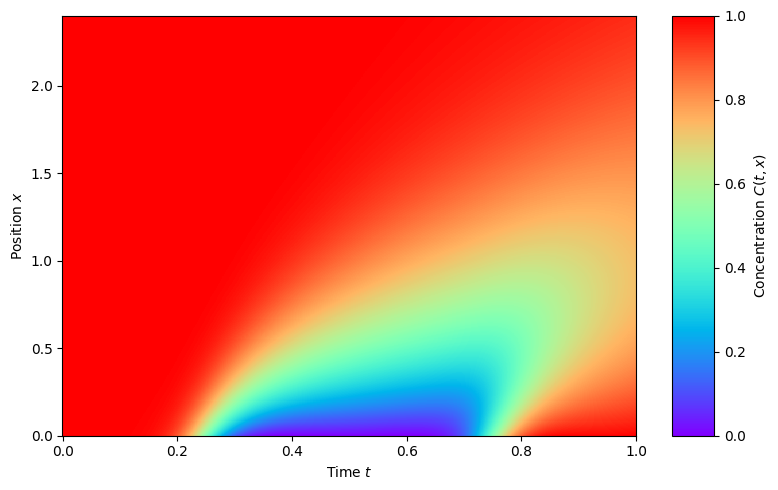

In [15]:
# Plot C(t,x) distribution as a colormap
fig, ax = plt.subplots(figsize=(8, 5))
mesh = ax.pcolormesh(t, x, c, cmap='rainbow', shading='auto')
ax.set_xlabel('Time $t$')
ax.set_ylabel('Position $x$')
ax.set_ylim(0, maxX * 0.4)

cbar = plt.colorbar(mesh, pad=0.05, aspect=10, ax=ax)
cbar.set_label('Concentration $C(t,x)$')
mesh.set_clim(0.0, 1)

fig.tight_layout()
plt.show()

We know how the potential $\theta$ changes over time given the starting potential, reversing potential, and scan rate $\sigma$ we specified.

With the predicted concentration, we can calculate flux with the finite difference approximation of __Fick’s first law of diffusion__.
$$
J(t,x) = -D \frac{\partial C}{\partial x}
$$

$$
J(t,x) ≈ -D \frac{C(t, x_1) - C(t,x_2)}{x_1-x_0}
$$

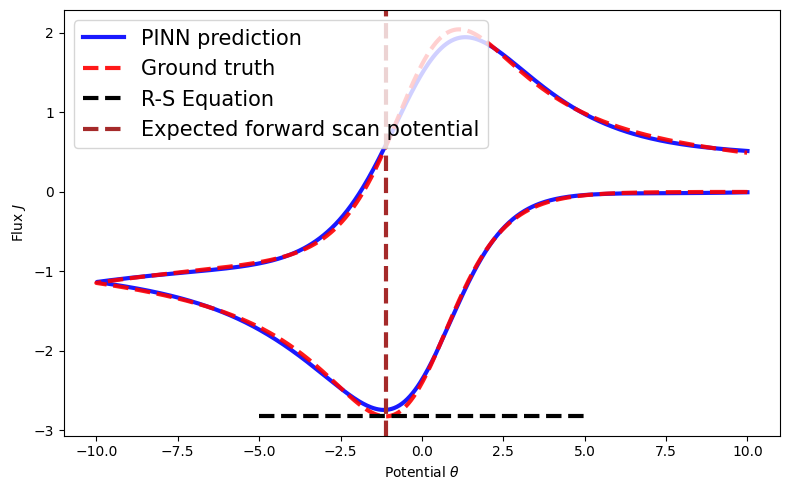

In [16]:
cv_flat = np.where(t_flat < maxT / 2.0, theta_i - sigma * t_flat, theta_v + sigma * (t_flat - maxT / 2.0))

x_i = x_flat[1]
flux = -(c[1,:] - c[0,:]) / x_i
df = pd.DataFrame({'Potential': cv_flat, 'Flux': flux})

# Flux vs Potential and ground truth
fig, ax = plt.subplots(figsize=(8, 5))
df.plot(x='Potential', y='Flux', ax=ax, color='b', lw=3, alpha=0.9, label='PINN prediction')

#Download ground truth data
! wget -q https://raw.githubusercontent.com/nmerovingian/PINN-CV/refs/heads/main/1D%20Semi-Infinite/FD-sigma%3D40.txt
df_fd = pd.read_csv('FD-sigma=40.txt',header=None)
df_fd.plot(x=0,y=1,ax=ax,color='r',ls='--',lw=3,alpha=0.9,label='Ground truth')

ax.plot([-5, 5], [-0.446 * np.sqrt(sigma), -0.446 * np.sqrt(sigma)],
         label='R-S Equation', ls='--', color='k', lw=3)

ax.axvline(-1.109, label='Expected forward scan potential', ls='--', color='brown', lw=3)

ax.set_xlabel(r'Potential $\theta$')
ax.set_ylabel(r'Flux $J$')

ax.legend(fontsize=15)
fig.tight_layout()
plt.show()